### Early stopping

If no improvement of a model after a given number of traing, it is better to stop a learnig.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import torch
from torch import optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision

In [40]:
class MyDataset(Dataset):
    def __init__(self,X,y,transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        return X, y

class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        super().__init__()
        self.flatten = nn.Flatten()  # flatten llayer [b,c,h,w] -> [b, cxhxw]
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out)

    def forward(self, X):
        flatten_X = self.flatten(X)
        z1 = self.l1(flatten_X)
        a1 = F.relu(z1)
        x = self.l2(a1)

        return x
       

In [62]:
def learning(model, train_loader, val_loader, opti, loss_func, num_epochs, early_stopping=None):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    no_improve = 0
    
    for epoch in range(num_epochs):
        
        running_loss = 0
        running_val_loss = 0
        running_val_acc = 0
        
        for train_batch, data in enumerate(train_loader):
    
            X, y = data
            
            opt.zero_grad()
            preds = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
            
            loss.backward()
            opt.step()
    
        # validation
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                
                X_val, y_val = data
                
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=1)==y_val) / y_val.shape[0]
                running_val_acc += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch+1))
        val_losses.append(running_val_loss/(val_batch+1))
        val_accuracies.append(running_val_acc/(val_batch +1))
    
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')
    
        # update best_val_losses and reset no_improve counter
        if val_losses[-1] < best_val_loss :
            best_val_loss = val_losses[-1]
            no_improve=0
        else:
            no_improve+=1

        # premature termination of the loop
        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
    
            break

    return train_losses, val_losses, val_accuracies, best_val_loss

In [63]:
num_epochs = 100
num_feature = 64
num_hidden = 30
num_class = 10

learning_rate = 0.1

model = MLP(num_feature, num_hidden, num_class)
opt = optim.SGD(params=model.parameters(), lr=learning_rate) # SGD : stochastic gradient descent algorithm

dataset = datasets.load_digits()
data = dataset['data']
target = dataset['target']
images = dataset['images']
images = images * (255. / 16.) # 0-16 -> 0-255
images = images.astype(np.uint8)
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),std=(0.5,))])

train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

train_losses, val_losses, val_accuracies, best_val_loss = learning(model, train_loader, val_loader, opt, F.cross_entropy, num_epochs=100, early_stopping=5)

epoch: 0: train error: 1.8961838616265192, validation error: 1.3168326715628307, validation accuracy: 0.7630208333333334
epoch: 1: train error: 0.8865621195899116, validation error: 0.5778297632932663, validation accuracy: 0.8776041666666666
epoch: 2: train error: 0.45411984589364796, validation error: 0.37721556673447293, validation accuracy: 0.9010416666666666
epoch: 3: train error: 0.3108562664853202, validation error: 0.2668800875544548, validation accuracy: 0.9270833333333334
epoch: 4: train error: 0.23869303233093686, validation error: 0.2233052228887876, validation accuracy: 0.9348958333333334
epoch: 5: train error: 0.20508514377805923, validation error: 0.18972657869259515, validation accuracy: 0.9453125
epoch: 6: train error: 0.17461058662997353, validation error: 0.17686347228785357, validation accuracy: 0.9479166666666666
epoch: 7: train error: 0.15530375523699655, validation error: 0.15554431391259035, validation accuracy: 0.9557291666666666
epoch: 8: train error: 0.1408178

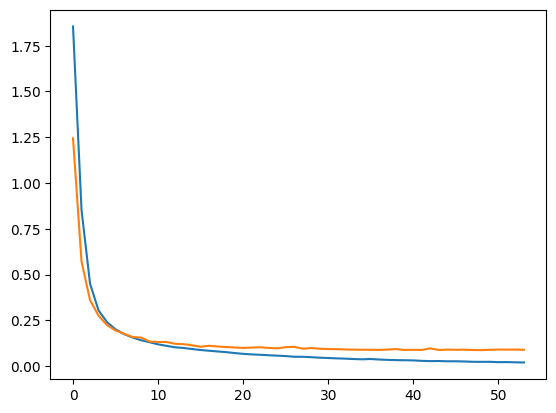

In [60]:
plt.plot(train_losses)
plt.plot(val_losses)

### Save and Load Model Object

```python
torch.save(model, PATH)

model = torch.load(PATH, weights_only=False)
model.eval()
```
A common PyTorch convention is to save models using either a `.pt` or `.pth` file extension.

[Saving and Loading Models](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [48]:
torch.save(model, './models/sample_model.pth')

In [49]:
loaded_model = torch.load('./models/sample_model.pth')
loaded_model

/tmp/ipykernel_11956/2028156232.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('./models/sample_model.pth')


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=64, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=10, bias=True)
)

### Save and Load Model Paremters

Save/Load state_dict (*Recommended*)
> **What is a state_dict?** <br>
In PyTorch, the learnable parameters (i.e. weights and biases) of an `torch.nn.Module` model are contained in the model’s parameters (accessed with `model.parameters()`). A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor. Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) and registered buffers (batchnorm’s running_mean) have entries in the model’s state_dict. Optimizer objects (`torch.optim`) also have a state_dict, which contains information about the optimizer’s state, as well as the hyperparameters used.

>Because state_dict objects are Python dictionaries, they can be easily saved, updated, altered, and restored, adding a great deal of modularity to PyTorch models and optimizers.
<br>

**save model's parameters**
```python
torch.save(model.state_dict(), PATH)
```
<br>

**load model's parameters** <br>

`torch.nn.Module.load_state_dict`: Loads a model’s parameter dictionary using a deserialized state_dict. 
<br>

**Parameters**

* **state_dict** (dict) – a dict containing parameters and persistent buffers.

* **strict** (bool, optional) – whether to strictly enforce that the keys in state_dict match the keys returned by this module’s state_dict() function. Default: True

* **assign** (bool, optional) – When False, the properties of the tensors in the current module are preserved while when True, the properties of the Tensors in the state dict are preserved. The only exception is the requires_grad field of Default: `False`.

In [52]:
# get model's params in dictionary
params = model.state_dict()
another_model = MLP(64,30,10)

# apply model's params to a new model
another_model.load_state_dict(params)

<All keys matched successfully>

In [53]:
another_model.l1.weight

Parameter containing:
tensor([[-0.0292, -0.1427, -0.2828,  ...,  0.4485,  0.2720,  0.1581],
        [-0.1987, -0.0978, -0.0336,  ...,  0.3137,  0.1640,  0.1049],
        [ 0.0949, -0.0245,  0.0855,  ...,  0.0829,  0.0936,  0.0468],
        ...,
        [-0.0769, -0.0353,  0.4033,  ..., -0.0818, -0.1309,  0.0666],
        [-0.0746, -0.0550, -0.0898,  ...,  0.4137,  0.0217, -0.1428],
        [-0.2613, -0.1786, -0.0490,  ..., -0.2518, -0.0983, -0.1069]],
       requires_grad=True)

In [54]:
model.l1.weight

Parameter containing:
tensor([[-0.0292, -0.1427, -0.2828,  ...,  0.4485,  0.2720,  0.1581],
        [-0.1987, -0.0978, -0.0336,  ...,  0.3137,  0.1640,  0.1049],
        [ 0.0949, -0.0245,  0.0855,  ...,  0.0829,  0.0936,  0.0468],
        ...,
        [-0.0769, -0.0353,  0.4033,  ..., -0.0818, -0.1309,  0.0666],
        [-0.0746, -0.0550, -0.0898,  ...,  0.4137,  0.0217, -0.1428],
        [-0.2613, -0.1786, -0.0490,  ..., -0.2518, -0.0983, -0.1069]],
       requires_grad=True)

So, the another_model has the same parameters with model.

In [55]:
torch.save(model.state_dict(), './models/torch_model_state_dict.pth')

In [56]:
another_model = MLP(64,30,10)
another_model.load_state_dict(torch.load('./models/torch_model_state_dict.pth'))

/tmp/ipykernel_11956/4101048777.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  another_model.load_state_dict(torch.load('./models/torch_model_state_dict.pth'))


<All keys matched successfully>

##### Add save model's parameters

In [78]:
def learning(model, train_loader, val_loader, opt, loss_func, num_epochs, early_stopping=None, save_path=None):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    no_improve = 0
    
    for epoch in range(num_epochs):
        
        running_loss = 0
        running_val_loss = 0
        running_val_acc = 0
        
        for train_batch, data in enumerate(train_loader):
    
            X, y = data
            
            opt.zero_grad()
            preds = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
            
            loss.backward()
            opt.step()
    
        # validation
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                
                X_val, y_val = data
                
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=1)==y_val) / y_val.shape[0]
                running_val_acc += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch+1))
        val_losses.append(running_val_loss/(val_batch+1))
        val_accuracies.append(running_val_acc/(val_batch +1))
    
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')
    
        # update best_val_losses and reset no_improve counter
        if val_losses[-1] < best_val_loss :
            best_val_loss = val_losses[-1]
            no_improve=0

            # save params
            if save_path is not None:
                state = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict':opt.state_dict(),
                    'val_loss':val_losses[-1]
                }
                torch.save(state, save_path)
            
        else:
            no_improve+=1

        # premature termination of the loop
        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            idx = val_losses.index(best_val_loss)
            print(f'lowest validation error {best_val_loss}, validation accuracy {val_accuracies[idx]}, epoch {idx}')
            break

    return train_losses, val_losses, val_accuracies

In [81]:
num_epochs = 100
num_feature = 64
num_hidden = 30
num_class = 10

learning_rate = 0.1

model = MLP(num_feature, num_hidden, num_class)
opt = optim.SGD(params=model.parameters(), lr=learning_rate) # SGD : stochastic gradient descent algorithm

dataset = datasets.load_digits()
data = dataset['data']
target = dataset['target']
images = dataset['images']
images = images * (255. / 16.) # 0-16 -> 0-255
images = images.astype(np.uint8)
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),std=(0.5,))])

train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

train_losses, val_losses, val_accuracies = learning(model, train_loader, val_loader, opt, F.cross_entropy, num_epochs=100, early_stopping=5,save_path='./models/checkpoint')

epoch: 0: train error: 1.9119846079084608, validation error: 1.376821865638097, validation accuracy: 0.7864583333333334
epoch: 1: train error: 0.8824504839049445, validation error: 0.6060402393341064, validation accuracy: 0.8776041666666666
epoch: 2: train error: 0.4403912189933989, validation error: 0.3628002926707268, validation accuracy: 0.9270833333333334
epoch: 3: train error: 0.2962632099787394, validation error: 0.27664264912406605, validation accuracy: 0.921875
epoch: 4: train error: 0.23119613379240037, validation error: 0.24974935005108514, validation accuracy: 0.9348958333333334
epoch: 5: train error: 0.19280172304974663, validation error: 0.20721936598420143, validation accuracy: 0.9375
epoch: 6: train error: 0.16721694982714122, validation error: 0.1883827211956183, validation accuracy: 0.9375
epoch: 7: train error: 0.15186845651931233, validation error: 0.16507991682738066, validation accuracy: 0.9479166666666666
epoch: 8: train error: 0.1350271775490708, validation error

In [83]:
state = torch.load('./models/checkpoint')
state

/tmp/ipykernel_11956/3350620968.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('./models/checkpoint')


{'model_state_dict': OrderedDict([('l1.weight',
               tensor([[ 0.0225, -0.0140, -0.1645,  ...,  0.1484, -0.1076,  0.0362],
                       [-0.0640,  0.0876,  0.1976,  ...,  0.2900,  0.2857, -0.0144],
                       [-0.2432, -0.2231, -0.2752,  ..., -0.0853, -0.1537, -0.1530],
                       ...,
                       [ 0.0730,  0.1089,  0.0837,  ..., -0.0698,  0.0029,  0.0557],
                       [-0.1640, -0.0304, -0.1817,  ...,  0.0833, -0.2174, -0.0019],
                       [ 0.0205, -0.0455, -0.0052,  ...,  0.3358,  0.1818,  0.1331]])),
              ('l1.bias',
               tensor([-0.0493,  0.0271,  0.1941,  0.0708,  0.1463, -0.0124, -0.0146,  0.2290,
                       -0.0788,  0.1896, -0.0266,  0.0639, -0.0321,  0.0805,  0.0445,  0.0820,
                        0.0505, -0.0685, -0.0953, -0.0483,  0.1278,  0.0709,  0.1862,  0.1266,
                       -0.0322,  0.0412, -0.0178,  0.0882,  0.1366,  0.0073])),
              ('l2.w

In [85]:
model.load_state_dict(state['model_state_dict'])
opt.load_state_dict(state['optimizer_state_dict'])